**Problema de negócio**: construir modelo de classificação binária para prever a direção (queda ou subida) do índice S&P 500 entre os anos 2001 até 2005.
Disponível em: https://rdrr.io/cran/ISLR/man/Smarket.html



**Benefícios do modelo de classificação para o caso**:<br>
- pode ser utilizado como indicador para tomada de decisões;
- utilizado como pipeline para quaisquer análises binárias;
- fácil compreensão para aqueles não técnicos.

Para o nosso caso, usaremos o KNN (K-nearest neighbors).

**Criando CSV**: a fonte de dados é própria para a linguagem R, logo, precisamos utilizar o recurso de utilizar o R no colab para extrair os dados em forma de csv, assim, conseguimos utiliza-la com python. Para utilizar, basta remover as # e executar os três scripts abaixo.

In [ ]:
# %load_ext rpy2.ipython

In [ ]:
# %%R
# install.packages("ISLR")
# library(ISLR)
# data("Smarket")
# write.csv(Smarket, file = "Smarket.csv", row.names = FALSE)

In [ ]:
# from google.colab import files
# files.download("Smarket.csv")

In [2]:
#conectando Google Drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Características Dataset**

**Labels**:
Um data frame com 1250 observações sobre as seguintes 9 variáveis:

**Year** - O ano em que a observação foi registrada

**Lag1** - Retorno percentual do dia anterior

**Lag2** - Retorno percentual de dois dias anteriores

**Lag3** - Retorno percentual de três dias anteriores

**Lag4** - Retorno percentual de quatro dias anteriores

**Lag5** - Retorno percentual de cinco dias anteriores

**Volume** - Volume de ações negociadas (número diário de ações negociadas em bilhões)

**Today** - Retorno percentual do dia atual

**Direction** - Um fator com os níveis Down e Up, indicando se o mercado teve um retorno negativo ou positivo em um determinado dia

In [28]:
#bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# **1 - Carregando Dataset e explorando dataset SP500**

In [4]:
path = '/content/drive/MyDrive/BD_MACHINE_LEARNING/SP500.csv'

In [5]:
df = pd.read_csv(path)
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 88.0+ KB


# **1.1 - Dividindo dados entre treino e teste**
Dividir os dados entre treinamento (train) e teste (test) é fundamental por um motivo principal: avaliar o desempenho real do modelo em dados que ele nunca viu antes. Em outras palavras:

- Se treinarmos e testarmos no mesmo conjunto de dados, o modelo pode "decorar" os dados — ou seja, aprender padrões muito específicos que não se generalizam. Isso é chamado de **overfitting**;
- O objetivo de um modelo preditivo é funcionar bem em novos dados. Usar um conjunto de teste separado permite simular esse cenário e medir se o modelo generaliza bem;
- É possível treinar vários modelos (ou ajustar hiperparâmetros) no conjunto de treino, mas deve-se avaliar o modelo final apenas no conjunto de teste — isso evita conclusões enviesadas;
- A separação ajuda a obter métricas como acurácia, precisão, recall, AUC, etc., com mais confiança — já que você estamos testando em dados "neutros", que o modelo nunca viu.



In [7]:
#dividindo dados entre train e test

from sklearn.model_selection import train_test_split

X = df.drop("Direction", axis=1)  # Features (exclui a variável-alvo)
y = df["Direction"]               # Variável-alvo

# Dividindo: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
X.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213


In [9]:
y.head()

,Direction
0,Up
1,Up
2,Down
3,Up
4,Up


# **1.2 - Verificando a distriuição das classes no conjunto original e nas partições train/test**

In [10]:
# Distribuição no conjunto original
print("Distribuição total:")
print(df["Direction"].value_counts(normalize=True))

# Distribuição no treino
print("\nDistribuição no treino:")
print(y_train.value_counts(normalize=True))

# Distribuição no teste
print("\nDistribuição no teste:")
print(y_test.value_counts(normalize=True))

Distribuição total:
Direction
Up      0.5184
Down    0.4816
Name: proportion, dtype: float64

Distribuição no treino:
Direction
Up      0.518
Down    0.482
Name: proportion, dtype: float64

Distribuição no teste:
Direction
Up      0.52
Down    0.48
Name: proportion, dtype: float64


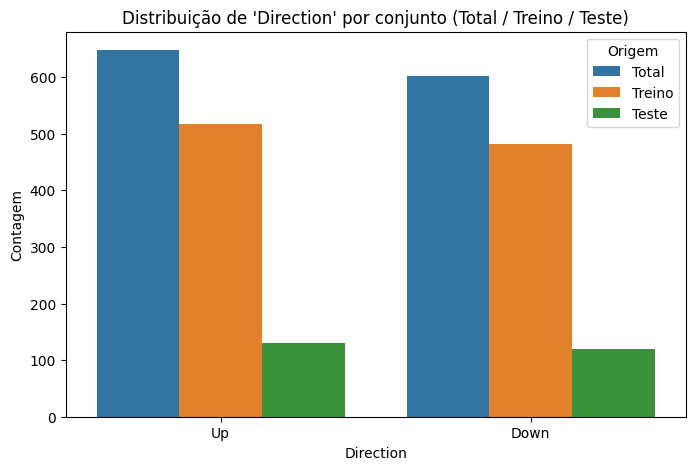

In [11]:
# Criar DataFrames temporários com identificação do grupo
df_total = df.copy()
df_total["Origem"] = "Total"

train_df = X_train.copy()
train_df["Direction"] = y_train
train_df["Origem"] = "Treino"

test_df = X_test.copy()
test_df["Direction"] = y_test
test_df["Origem"] = "Teste"

# Concatenar tudo
distribuicao_df = pd.concat([df_total, train_df, test_df])

# Gráfico
plt.figure(figsize=(8, 5))
sns.countplot(data=distribuicao_df, x="Direction", hue="Origem")
plt.title("Distribuição de 'Direction' por conjunto (Total / Treino / Teste)")
plt.ylabel("Contagem")
plt.show()


In [12]:
df_train = train_df.drop(columns='Origem', errors='ignore')
df_test = test_df.drop(columns='Origem', errors='ignore')

# **1.3 - Correlação entre as variáveis preditoras**

**Importancia de verificar se há correlação**:
- Detectar se há multicolinearidade (variáveis muito correlacionadas entre si, o que pode afetar modelos lineares);

- Entender relações estruturais entre atributos;

- Decidir se vale a pena fazer redução de dimensionalidade.


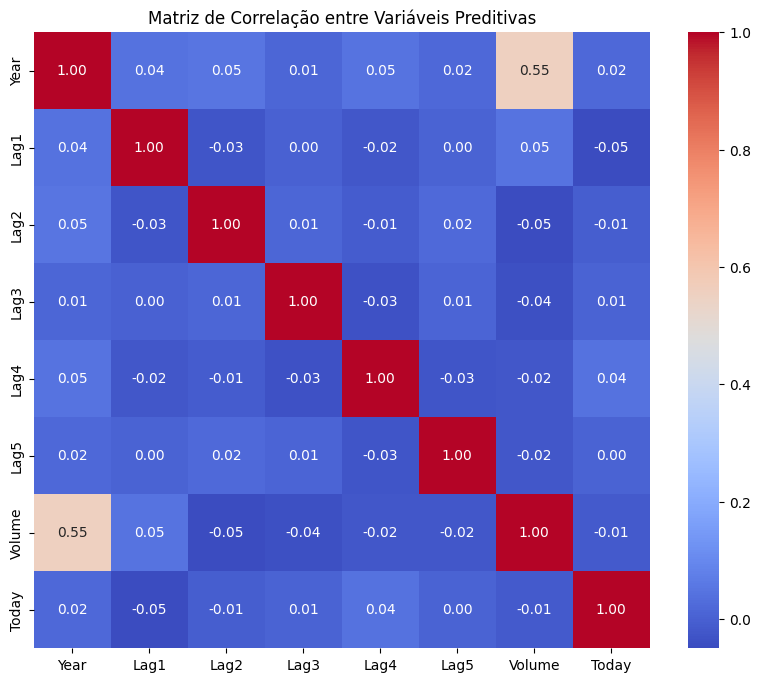

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar apenas as variáveis preditoras numéricas
variaveis_numericas = X_train.select_dtypes(include='number')

# Matriz de correlação
correlacao = variaveis_numericas.corr()

# Visualização com mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlação entre Variáveis Preditivas")
plt.show()

- Valores próximos de +1 ou –1 indicam correlação forte (direta ou inversa);

- Valores próximos de 0 indicam correlação fraca ou inexistente;

- Em modelos como regressão logística, correlações muito fortes entre preditoras (ex: > 0.8) podem causar instabilidade.

No nosso caso, as correlações são fracas. Por exemplo: A variação que ocorre em em "Today" não explica sozinha o que acontece em "Year", o que reflete a realidade. Já "Volume" e "Year" apresentam um comportamento diferente: quanto maior o volume, maior o índice no ano, o que também é compreensível. Nesse sentido, não temos uma multicolinearidade.

# **2 - Pre-processamento - normalização dos dados em Center e Scale**

Knn requer dados normalizados.
- Center: calcula média de um atributo e subtrai de cada valor;
- Scale: calcula desvio padrão para um atributo e divide cada valor pelo desvio padrão.

In [16]:
import numpy as np

# Função que aplica normalização (z-score) a colunas específicas de um DataFrame
def scale_features(df, variables):
    df_scaled = df.copy()
    for var in variables:
        media = df[var].mean()
        desvio = df[var].std()
        df_scaled[var] = (df[var] - media) / desvio
    return df_scaled

# Removendo a variável target ("Direction") dos dados
numeric_vars_train = df_train.drop(columns="Direction").columns
numeric_vars_test = df_test.drop(columns="Direction").columns

# Aplicando normalização aos preditores de treino e teste individualmente
df_train_scaled = scale_features(df_train, numeric_vars_train)
df_test_scaled = scale_features(df_test, numeric_vars_test)


In [17]:
df_train_scaled.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
315,-0.730716,-0.187695,2.069529,-0.699951,0.598582,-2.044400,-0.293943,-0.142804,Down
482,-0.730716,-0.342599,0.068342,1.215952,-1.927827,0.551504,-0.630952,-1.215204,Down
95,-1.441530,-1.084121,0.299450,-1.403426,-0.213447,1.407563,-1.814917,-0.712070,Down
264,-0.730716,-0.649657,1.326306,1.019654,-2.491687,-0.008227,-0.320826,-2.226835,Down
526,-0.019903,1.786642,1.895323,-0.166128,-1.095629,-0.693594,-0.643423,-0.650407,Down


In [18]:
df_test_scaled.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1202,1.431470,0.104222,-1.453030,1.345680,-0.965372,0.205988,2.819904,1.440031,Up
278,-0.681921,0.617942,-1.497256,1.223388,-1.745410,-1.041901,-0.135749,1.539716,Up
503,0.022543,0.434690,-0.224623,0.083962,1.638292,-1.315740,-0.223868,-1.152618,Down
1205,1.431470,-0.342790,-0.311270,1.499178,0.057875,-1.398695,2.811065,-0.824487,Down
962,0.727006,-0.065995,-0.196643,0.410355,1.352632,0.938309,-0.024765,-0.037804,Down


# **3 - Construção e Treinamendo do Modelo**

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Separando X e y
X_train = df_train_scaled.drop(columns="Direction")
y_train = df_train_scaled["Direction"]

# Repeated Cross-Validation (3 repetições, 5 folds)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=400)

# Grid de valores para k (n_neighbors)
param_grid = {
    'n_neighbors': list(range(1, 21))  # tuneLength = 20
}

# Instanciando o modelo
knn = KNeighborsClassifier()

# Otimizando com GridSearchCV
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='accuracy',
                           n_jobs=-1)

# Treinando
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_knn = grid_search.best_estimator_

In [20]:
print(f"Melhor valor de k: {grid_search.best_params_['n_neighbors']}")
print(f"Acurácia média (cross-val): {grid_search.best_score_:.4f}")

Melhor valor de k: 19
Acurácia média (cross-val): 0.8943


Em suma, a nossa acurácia é maior quando o k (ou número de vizinhos) é igual a 19, obtendo uma acurácia de 89.43%.

# **3.1 - Realizando Predições com dados de teste**



In [26]:
# Separar X e y do conjunto de teste
X_test = df_test_scaled.drop(columns='Direction')
y_test = df_test_scaled['Direction']

# Prever com o modelo treinado
knn_predict = best_knn.predict(X_test)

# Mostrar as previsões
print("Previsões do modelo no teste:")
print(knn_predict)

Previsões do modelo no teste:
['Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Down' 'Down'
 'Down' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down'
 'Down' 'Up' 'Down' 'Down' 'Down' 'Down' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Down' 'Down' 'Up' 'Down' 'Up' 'Up'
 'Down' 'Down' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Down' 'Up' 'Down' 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up' 'Down' 'Up'
 'Down' 'Down' 'Down' 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Down' 'Up'
 'Down' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Down' 'Up' 'Down' 'Up' 'Down' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up' 'Down'
 'Up' 'Up' 'Down' 'Up' 'Up' 'Down' 'Down' 'Up' 'Down' 'Up' 'Down' 'Up'
 'Down' 'Up' 'Down' 'Down' 'Down' 'Down' 'Down' 'Down' 'Up' 'Down' 'Up'
 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Down' 'Up' 'Up'
 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Down' 'Down' 'Down'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Down'

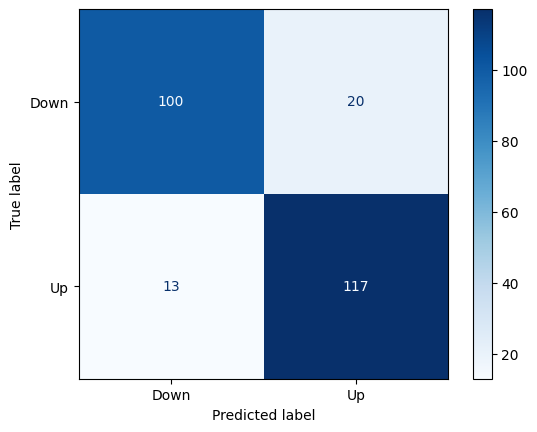

In [29]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, knn_predict, labels=["Down", "Up"])

# Exibir visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
disp.plot(cmap="Blues")

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Acurácia geral
acc = accuracy_score(y_test, knn_predict)

# Precisão, recall e F1 para cada classe
prec = precision_score(y_test, knn_predict, pos_label='Up')
rec = recall_score(y_test, knn_predict, pos_label='Up')
f1 = f1_score(y_test, knn_predict, pos_label='Up')

# Relatório completo
relatorio = classification_report(y_test, knn_predict, target_names=['Down', 'Up'])

# Exibir
print(f"Acurácia: {acc:.4f}")
print(f"Precisão (classe 'Up'): {prec:.4f}")
print(f"Recall (classe 'Up'): {rec:.4f}")
print(f"F1-score (classe 'Up'): {f1:.4f}")
print("\nRelatório completo:\n")
print(relatorio)

Acurácia: 0.8680
Precisão (classe 'Up'): 0.8540
Recall (classe 'Up'): 0.9000
F1-score (classe 'Up'): 0.8764

Relatório completo:

              precision    recall  f1-score   support

        Down       0.88      0.83      0.86       120
          Up       0.85      0.90      0.88       130

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250



# **4 - Explicando reusltados**

As métricas apresentadas mostram que o modelo knn teve um resultado bastante sólido:
- 	O modelo acertou 86,8% das previsões no total;
- 	Quando o modelo disse "Up", ele acertou 85,4% das vezes;
- 	O modelo conseguiu encontrar 90% de todos os dias em que o mercado realmente subiu;
- Combina precisão e recall — é ótimo quando há equilíbrio entre os dois.

**Relatório**:<br>
- *Down*:

Precisão: 88% dos dias previstos como "Down" realmente foram;<br>
Recall: 83% dos dias que de fato caíram foram detectados pelo modelo.

- *Up*:

Precisão: 85%;<br>
Recall: 90%;<br>
F1: 88%;<br>
Macro avg: Média simples entre classes (boa quando classes estão balanceadas);<br>
Weighted avg: Média ponderada pelo número de casos (melhor se há desequilíbrio).

**Conclusão**: Nosso modeloequilibrado entre classes (não favorece só “Up” ou só “Down”);<br>
Tem alto recall para “Up”, o que é excelente se seu foco for capturar oportunidades de alta no mercado;<br>
Está acertando bem acima do acaso (50%).